In [1]:
import os
import random
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from matplotlib.colors import ListedColormap

In [2]:
data_dir = os.path.join(os.getcwd(), 'data')
result_dir = os.path.join(os.getcwd(), 'results')
fig_dir = os.path.join(os.getcwd(), 'figures')
adata_name = '.h5ad' # adata file name
model = 'SAGE'

In [8]:
df = {}
for name in ['4.5_1', '4.5_2', '4.5_3', '6.5_1', '6.5_2', '9.5_1', '9.5_2', '9.5_3']:
    df[name] = pd.read_csv(os.path.join(data_dir, 'spots_PCW{}.csv'.format(name)))
    df[name]['pcw'] = int(name[0])
    df[name]['section'] = int(name[-1])
    df[name] = df[name].set_index('{}_'.format(name) + df[name].index.astype(str))
df_heart = pd.concat(df.values())
df_nodes = pd.read_csv(os.path.join(result_dir, 'nodes.csv'), index_col=0)
df_heart = df_heart.loc[df_nodes.index]

In [7]:
df_taglist = pd.read_csv(os.path.join(data_dir, 'taglist_heart.csv'), names=['tag', 'gene'])
gene_tag_dict = pd.Series(df_taglist['tag'].to_list(), index=df_taglist['gene']).to_dict()
df_heart['barcode'] = df_heart['gene'].map(gene_tag_dict)
df_heart

,gene,spotX,spotY,pcw,section,barcode
4.5_1_11,MYRF,3242.580,1736.800,4,1,TTTCC
4.5_1_33,MT2A,3288.139,1786.139,4,1,GTGAG
4.5_1_21,MYRF,3178.258,1768.548,4,1,TTTCC
4.5_1_28,SLC39A8,3266.824,1777.691,4,1,CCAAA
4.5_1_18,ITLN1,3217.077,1764.718,4,1,TCGGC
...,...,...,...,...,...,...
9.5_3_538718,MYOM1,18049.890,24246.370,9,3,GTATC
9.5_3_538712,COL1A1,18189.620,24235.260,9,3,ACACA
9.5_3_538713,FBLN5,18177.570,24237.700,9,3,CACGC
9.5_3_538716,COL1A2,18142.730,24242.730,9,3,ACCGC


In [11]:
adata = sc.read(os.path.join(result_dir, adata_name))
df_heart['cluster'] = adata.obs['louvain'].astype('int64')
print(df_heart['cluster'].value_counts())

SAGE-20200817.h5ad
0     174811
1     159951
2     148647
3     144518
4     124170
5     119392
6     114093
7     113300
8     110954
9     109781
10    109701
11    106438
12     99396
13     88117
14     82918
15     76821
16     66760
17     66057
18     63079
19     60909
20     60089
21     55655
22     54229
23     44667
24     29566
25     26031
26      4044
27      3278
28       300
29        76
30        51
31        49
32        42
33        37
34        28
35         8
Name: cluster, dtype: int64


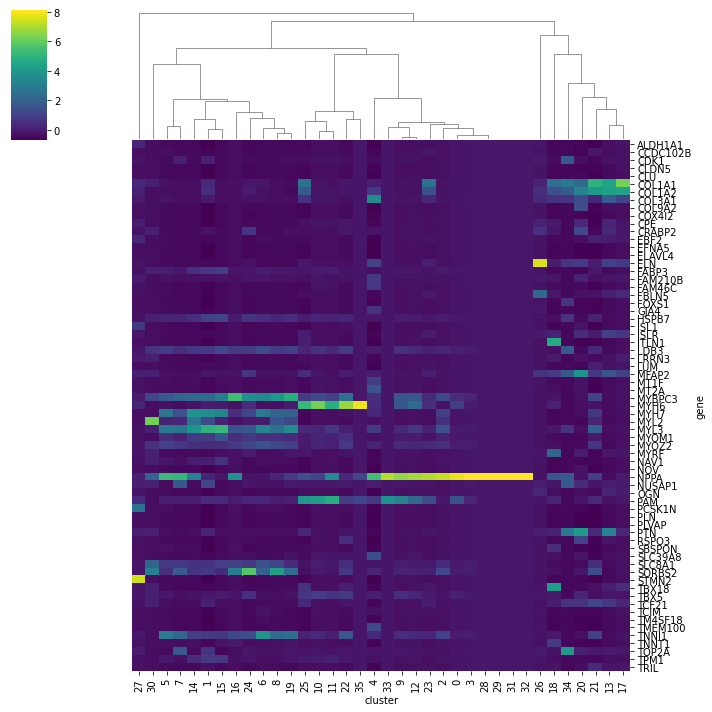

In [21]:
table1 = pd.crosstab(df_heart['gene'], df_heart['cluster'])
table1 = pd.DataFrame(data=StandardScaler().fit_transform(table1.to_numpy()), index=table1.index, columns=table1.columns)
g = sns.clustermap(
    table1, method='average', metric='correlation', row_cluster=False,
    cmap='viridis', xticklabels=True, yticklabels=True)

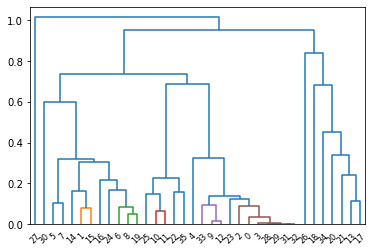

In [23]:
cutoff = 0.1
Z = linkage(table1.to_numpy().T, method='average', metric='correlation')
merged_labels = dict(zip(table1.columns, fcluster(Z, cutoff, criterion='distance')))
df_heart['cluster_merged'] = df_heart['cluster'].map(merged_labels)
dn = dendrogram(Z, color_threshold=cutoff)

In [24]:
cluster_size = df_heart['cluster_merged'].value_counts()
cluster_kept = cluster_size[cluster_size > 100].index
df_heart = df_heart[df_heart['cluster_merged'].isin(cluster_kept)]
print(df_heart.shape)

(2417876, 8)


In [25]:
_, indices = np.unique(df_heart['cluster_merged'], return_inverse=True)
df_heart['spage2vec_cluster'] = indices

In [26]:
adata.obs['spage2vec'] = df_heart['spage2vec_cluster']
adata.obs['spage2vec'] = adata.obs['spage2vec'].fillna(value=adata.obs['spage2vec'].nunique())
adata.obs['spage2vec'] = adata.obs['spage2vec'].astype('int64')
adata.write(os.path.join(result_dir, adata_name))

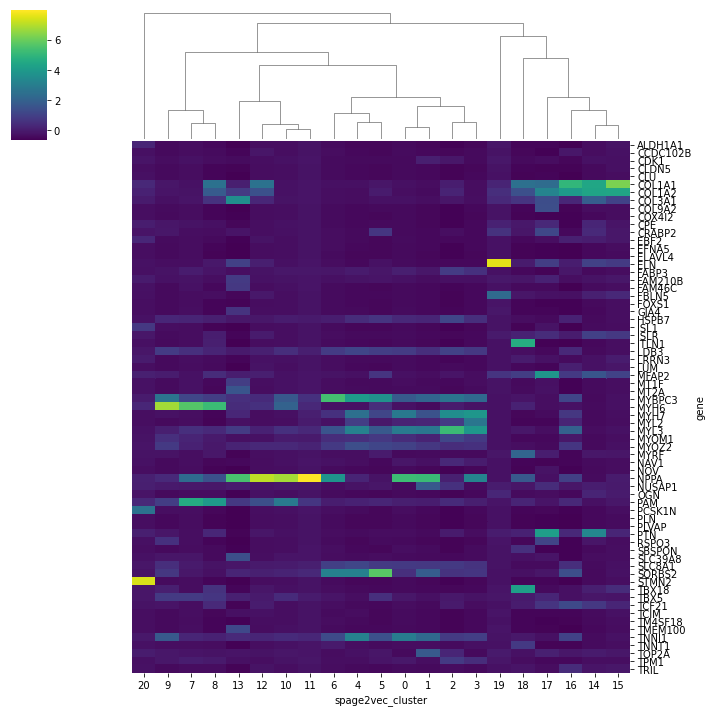

In [28]:
table2 = pd.crosstab(df_heart['gene'], df_heart['spage2vec_cluster'])
table2 = pd.DataFrame(data=StandardScaler().fit_transform(table2.to_numpy()), index=table2.index, columns=table2.columns)
g = sns.clustermap(
    table2, method='average', metric='correlation', row_cluster=False,
    cmap='viridis', xticklabels=True, yticklabels=True)
g.savefig(os.path.join(fig_dir, 'hm.png'))

In [29]:
df_celltype = pd.read_csv(os.path.join(result_dir, 'celltype.csv'), index_col=0)
df_heart_ct = pd.concat([df_heart, df_celltype], axis=1, join='inner')
df_heart_ct = df_heart_ct[df_heart_ct['cell_type_id'] >= 0]

In [30]:
df_heart['cell_type_id'] = df_celltype
df_heart['cell_type_id'] = df_heart['cell_type_id'].astype('Int64')

(21, 12)


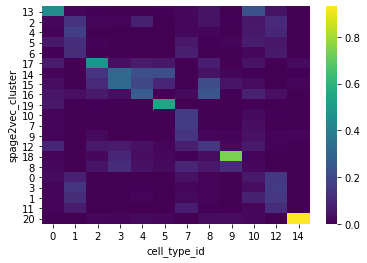

In [31]:
table3 = pd.crosstab(df_heart_ct['spage2vec_cluster'], df_heart_ct['cell_type_id'])
table3 = table3.divide(table3.sum(axis=1), axis=0)
table3 = table3.divide(table3.sum(axis=0), axis=1)
row_order = table3.idxmax(axis=1).sort_values().index
g = sns.heatmap(table3.reindex(row_order), cmap='viridis', xticklabels=True, yticklabels=True)
print(table3.shape)
g.figure.savefig(os.path.join(fig_dir, 'cm.png'))

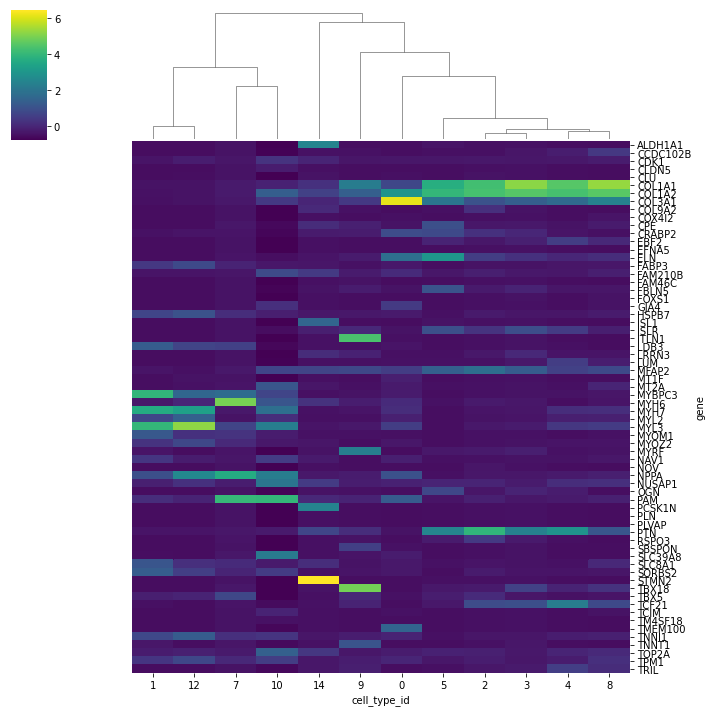

In [32]:
table4 = pd.crosstab(df_heart_ct['gene'], df_heart_ct['cell_type_id'])
table4 = pd.DataFrame(data=StandardScaler().fit_transform(table4.to_numpy()), index=table4.index, columns=table4.columns)
g = sns.clustermap(
    table4, method='average', metric='correlation', row_cluster=False,
    cmap='viridis', xticklabels=True, yticklabels=True)

In [33]:
for pcw in [4, 6, 9]:
    for section in [1, 2, 3]:
        if pcw == 6 and section == 3:
            continue
        if pcw == 6:
            columns = ['gene', 'barcode', 'spotX', 'spotY', 'spage2vec_cluster', 'cell_type_id']
        else:
            columns = ['gene', 'barcode', 'spotX', 'spotY', 'spage2vec_cluster']
        criterion = (df_heart['pcw']==pcw) & (df_heart['section']==section)
        df_heart[columns][criterion].to_csv(
            os.path.join(result_dir, 'spage2vec_PCW{}.5_{}.csv'.format(pcw, section)))

In [ ]:
iwanthue_25 = [
    "#017f58", "#6400a1", "#67ea27", "#0144cb", "#f4de00",
    "#368aff", "#a7ff75", "#b20073", "#01f389", "#db0027",
    "#01ca8a", "#930039", "#9aff95", "#009ffb", "#3a7b00",
    "#ffa8c4", "#00a23d", "#521900", "#33d9ff", "#ffb85e",
    "#00333b", "#f2ffa3", "#a7d2ff", "#264b00", "#ffdfd8",
]

In [38]:
def spatial_plot(pcw):
    n_section = 2 if pcw == 6 else 3
    fig, axes = plt.subplots(1, n_section, figsize=(7 * n_section, 7))
    for s in range(n_section):
        subset = (df_heart['pcw'] == pcw) & (df_heart['section'] == s+1)
        spot_x = df_heart.loc[subset,'spotX']
        spot_y = df_heart.loc[subset,'spotY']
        if pcw == 6:
            spot_x = spot_x.max() - spot_x
        spot_y = spot_y.max() - spot_y
        axes[s].scatter(
            spot_x, 
            spot_y, 
            s=0.5, 
            c=df_heart.loc[subset,'spage2vec_cluster'], 
            marker='.', 
            cmap=ListedColormap(iwanthue_25),
            alpha=1.0, 
            linewidths=0
        )
        axes[s].set_title('{}.5_{}'.format(pcw, s+1))
        axes[s].grid(False)
    fig.tight_layout()
    fig.savefig(os.path.join(fig_dir, 'spatial-{}-{}.png'.format(model, pcw)), dpi=500)
    plt.close()

In [39]:
for pcw in [4, 6, 9]:
    spatial_plot(pcw)

In [40]:
ct_cmap = [
    '#F8766D', '#E58700', '#C99800', '#A3A500', '#6BB100',
    '#00BA38', '#00BF7D', '#00C0AF', '#00BCD8', '#00B0F6', 
    '#619CFF', '#B983FF', '#E76BF3', '#FD61D1', '#FF67A4'
]

In [46]:
df_cell = {}
for name in ['6.5_1', '6.5_2']:
    df_cell_segmentation = pd.read_csv(os.path.join(data_dir, 'spots_w_cell_segmentation_PCW{}.csv'.format(name)))
    df_cell_calling = pd.read_csv(os.path.join(data_dir, 'cell_calling_PCW{}.csv'.format(name)))
    df_cell[name] = pd.merge(
        df_cell_segmentation, df_cell_calling[['cell', 'celltype']], 
        how='left', left_on='parent_id', right_on='cell'
    )
    df_cell[name]['pcw'] = int(name[0])
    df_cell[name]['section'] = int(name[-1])
    df_cell[name] = df_cell[name].set_index('{}_'.format(name) + df_cell[name].index.astype(str))
df_heart_cell = pd.concat(df_cell.values())
cell_types = df_heart_cell['celltype'].dropna().unique()
cell_type_id = [(cell_type, int(re.search(r'\((\d+)\)', cell_type).group(1))) for cell_type in cell_types]
cell_type_id.append(('Uncalled', -1))
cell_type_id.sort(key=lambda x: x[1])
cell_type_id = dict(cell_type_id)
df_heart_cell['celltype'].fillna(value='Uncalled', inplace=True)
df_heart_cell['cell_type_id'] = df_heart_cell['celltype'].map(cell_type_id)

fig, axes = plt.subplots(1, 3, figsize=(21, 7))
cmap = ListedColormap(ct_cmap)
subset = (df_heart['pcw'] == 6) & (df_heart['section'] == 2)
spot_x = df_heart.loc[subset,'spotX']
spot_y = df_heart.loc[subset,'spotY']
spot_x = spot_x.max() - spot_x
spot_y = spot_y.max() - spot_y
axes[0].scatter(
    spot_x, 
    spot_y, 
    s=0.5, 
    c=df_heart.loc[subset,'spage2vec_cluster'], 
    marker='.', 
    cmap=ListedColormap(iwanthue_25),
    alpha=1.0, 
    linewidths=0
)
axes[0].set_title('spage2vec')
subset = (df_heart_cell['section'] == 2) & (df_heart_cell['cell_type_id'] >= 0)
labels = list(cell_type_id.keys())[1:]
spot_x = df_heart_cell.loc[subset,'spotX']
spot_y = df_heart_cell.loc[subset,'spotY']
spot_x = spot_x.max() - spot_x
spot_y = spot_y.max() - spot_y
scatter = axes[1].scatter(
    spot_x, 
    spot_y, 
    s=0.5, 
    c=df_heart_cell.loc[subset,'cell_type_id'], 
    marker='.', 
    cmap=cmap, 
    vmin=0, 
    vmax=14, 
    alpha=1.0, 
    linewidths=0
)
axes[1].set_title('pciSeq')
axes[2].legend(
    handles=scatter.legend_elements(num=None)[0], 
    labels=labels, 
    loc='center left', 
    bbox_to_anchor=(0, 0.5)
)
axes[2].axis('off')
fig.tight_layout()
fig.savefig(os.path.join(fig_dir, 'spatial-{}.png'.format(model)), dpi=500)
plt.close()